In [1]:
from gcn_scripts import GCN_Model, graph, coarsening
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\s

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [3]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [4]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [5]:
train_set = train_set.reshape((-1,64,64))
train_set = np.transpose(train_set, (0, 2, 1))
test_set = test_set.reshape((-1,64,64))
test_set = np.transpose(test_set, (0, 2, 1))
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392,) (3598, 64, 64) (3598,)


In [6]:
#set data for gcn model
train_label_holder = np.ones((0))
test_label_holder = np.ones((0))

for i in range(train_set.shape[0]):
    temp = np.full((64), train_label[i])
    train_label_holder = np.concatenate((train_label_holder, temp), axis=0)
    
for i in range(test_set.shape[0]):
    temp = np.full((64), test_label[i])
    test_label_holder = np.concatenate((test_label_holder, temp), axis=0)

train_set = train_set.reshape((-1,64))
test_set = test_set.reshape((-1,64))
train_label = train_label_holder
test_label = test_label_holder
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(921088, 64) (921088,) (230272, 64) (230272,)


In [7]:
dist, idx = graph.distance_scipy_spatial(train_set.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

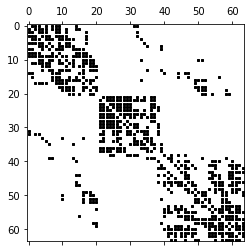

In [8]:
plt.spy(A, markersize=2, color='black');

In [9]:
graphs, perm = coarsening.coarsen(A, levels=5, self_connections=False)

Layer 0: M_0 = |V| = 96 nodes (32 added),|E| = 401 edges
Layer 1: M_1 = |V| = 48 nodes (15 added),|E| = 172 edges
Layer 2: M_2 = |V| = 24 nodes (7 added),|E| = 65 edges
Layer 3: M_3 = |V| = 12 nodes (3 added),|E| = 23 edges
Layer 4: M_4 = |V| = 6 nodes (1 added),|E| = 9 edges
Layer 5: M_5 = |V| = 3 nodes (0 added),|E| = 3 edges


In [10]:
X_train = coarsening.perm_data(train_set, perm)
X_test  = coarsening.perm_data(test_set,  perm)

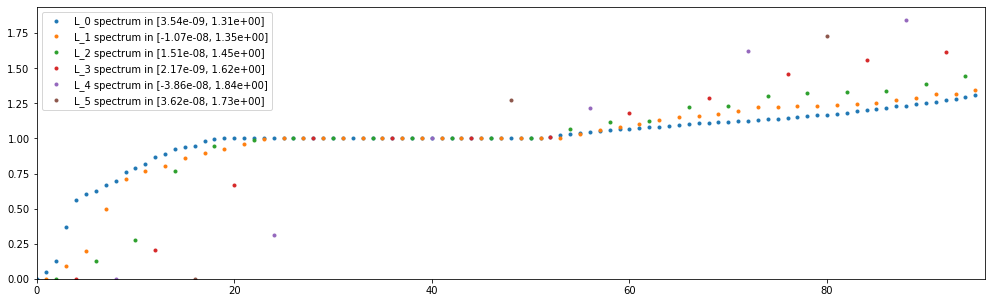

In [11]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [12]:
params = dict()
params['dir_name']       = 'Graph_Convolutional_Neural_Network'
params['num_epochs']     = 100
params['batch_size']     = 1024
params['eval_frequency'] = 100

# Building blocks.
params['filter'] = 'chebyshev5'
params['brelu']  = 'b2relu'
params['pool']   = 'mpool1'

# Architecture.
params['F'] = [16, 32, 64, 128, 256, 512]  # Number of graph convolutional filters.
params['K'] = [2, 2, 2, 2, 2, 2]           # Polynomial orders.
params['p'] = [2, 2, 2, 2, 2, 2]           # Pooling sizes.
params['M'] = [4]                          # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0.001     # L2 regularization
params['dropout']        = 0.50      # Dropout rate
params['learning_rate']  = 0.000001  # Learning rate
params['decay_rate']     = 1         # Learning rate Decay == 1 means no Decay
params['momentum']       = 0         # momentum == 0 means Use Adam Optimizer
params['decay_steps']    = np.shape(train_set)[0] / params['batch_size']


In [ ]:
model = GCN_Model.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, train_label, X_test, test_label)

NN architecture
input: M_0 = 96
layer 1: cgconv1
representation: M_0 * F_1 / p_1 = 96 * 16 / 2 = 768
weights: F_0 * F_1 * K_1 = 1 * 16 * 2 = 32
biases: M_1 * F_1 = 96 * 16 = 1536
layer 2: cgconv2
representation: M_1 * F_2 / p_2 = 48 * 32 / 2 = 768
weights: F_1 * F_2 * K_2 = 16 * 32 * 2 = 1024
biases: M_2 * F_2 = 48 * 32 = 1536
layer 3: cgconv3
representation: M_2 * F_3 / p_3 = 24 * 64 / 2 = 768
weights: F_2 * F_3 * K_3 = 32 * 64 * 2 = 4096
biases: M_3 * F_3 = 24 * 64 = 1536
layer 4: cgconv4
representation: M_3 * F_4 / p_4 = 12 * 128 / 2 = 768
weights: F_3 * F_4 * K_4 = 64 * 128 * 2 = 16384
biases: M_4 * F_4 = 12 * 128 = 1536
layer 5: cgconv5
representation: M_4 * F_5 / p_5 = 6 * 256 / 2 = 768
weights: F_4 * F_5 * K_5 = 128 * 256 * 2 = 65536
biases: M_5 * F_5 = 6 * 256 = 1536
layer 6: cgconv6
representation: M_5 * F_6 / p_6 = 3 * 512 / 2 = 768
weights: F_5 * F_6 * K_6 = 256 * 512 * 2 = 262144
biases: M_6 * F_6 = 3 * 512 = 1536
layer 7: logits (softmax)
representation: M_7 = 4
weights: M